In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import itertools

from torch.utils.data import DataLoader
from torch import nn
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error

sys.path.append("..")
from utils import metrics
from utils.data import TimeFusionDataset
from timefusion import TimeFusion
from utils.early_stopper import EarlyStopper

In [2]:
# Import data
train_data = pd.read_csv("../../datasets/electricity/train.csv").set_index("date")
test_data = pd.read_csv("../../datasets/electricity/test.csv").set_index("date")
train_data = train_data.iloc[:,:90]
test_data = test_data.iloc[:,:90]

# Normalize the signal power of each column
stds = train_data.std()
train_data /= stds
test_data /= stds

In [3]:
# Compute device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

In [4]:
context_length = 96
prediction_length = 24

# Create datasets
train_dataset = TimeFusionDataset(
    data = train_data.iloc[:int(0.9*len(train_data))],
    context_length = context_length,
)
train_dataset.add_timestamp_encodings()

val_dataset = TimeFusionDataset(
    data = train_data.iloc[int(0.9*len(train_data)):],
    context_length = context_length,
)
val_dataset.add_timestamp_encodings()

test_dataset = TimeFusionDataset(
    data = test_data,
    context_length = context_length,
)
test_dataset.add_timestamp_encodings()

train_loader = DataLoader(
    dataset = train_dataset,
    shuffle = True,
    num_workers = 4,
    batch_size = 128,
)

val_loader = DataLoader(
    dataset = val_dataset,
    shuffle = True,
    num_workers = 4,
    batch_size = 128,
)

In [5]:
predictor = TimeFusion(
    input_size = train_dataset.data.shape[1],
    output_size = train_data.shape[1],
    rnn_layers = 2,
    rnn_hidden = 60,
    residual_layers = 4,
    residual_size = 60 + train_data.shape[1],
    residual_hidden = 100,
    scaling = True,
    device = device
)

print("Number of trainable parameters:",sum(p.numel() for p in predictor.parameters()))

/rds/general/user/ejh19/home/Final-Year-Project/TimeFusion/examples/../utils/diffusion.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.bar_alphas = torch.tensor(


Number of trainable parameters: 230560


In [6]:
predictor.modules

<bound method Module.modules of TimeFusion(
  (scaler): MeanScaler()
  (epsilon_theta): EpsilonTheta(
    (embedding): DiffusionEmbedding(
      (linear1): Linear(in_features=32, out_features=60, bias=True)
      (tanh): Tanh()
      (linear2): Linear(in_features=60, out_features=60, bias=True)
    )
    (rnn): LSTM(98, 60, num_layers=2, batch_first=True)
    (residuals): Sequential(
      (0): Linear(in_features=150, out_features=150, bias=True)
      (1): ResidualBlock(
        (linear1): Linear(in_features=150, out_features=100, bias=True)
        (relu): ReLU()
        (linear2): Linear(in_features=100, out_features=150, bias=True)
        (tanh): Tanh()
      )
      (2): ResidualBlock(
        (linear1): Linear(in_features=150, out_features=100, bias=True)
        (relu): ReLU()
        (linear2): Linear(in_features=100, out_features=150, bias=True)
        (tanh): Tanh()
      )
      (3): ResidualBlock(
        (linear1): Linear(in_features=150, out_features=100, bias=True)
   

In [7]:
# optimizer = torch.optim.Adam(params=predictor.parameters(),lr=4e-4)
# lr_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.01, total_iters=120)

# predictor.train_network(
#     train_loader = train_loader,
#     epochs=120,
#     val_loader = val_loader,
#     val_metrics= {
#         "Val MAE": nn.L1Loss(),
#     },
#     optimizer = optimizer,
#     lr_scheduler= lr_scheduler,
#     early_stopper=EarlyStopper(patience=20),
#     save_weights = True,
#     weight_folder = "weights/electricity"
# )

In [7]:
# Load weights as an alternative to training
predictor.load_state_dict(torch.load("weights/electricity/2023-05-26-01-05-47",map_location=device))
predictor.eval()

TimeFusion(
  (scaler): MeanScaler()
  (epsilon_theta): EpsilonTheta(
    (embedding): DiffusionEmbedding(
      (linear1): Linear(in_features=32, out_features=60, bias=True)
      (tanh): Tanh()
      (linear2): Linear(in_features=60, out_features=60, bias=True)
    )
    (rnn): LSTM(98, 60, num_layers=2, batch_first=True)
    (residuals): Sequential(
      (0): Linear(in_features=150, out_features=150, bias=True)
      (1): ResidualBlock(
        (linear1): Linear(in_features=150, out_features=100, bias=True)
        (relu): ReLU()
        (linear2): Linear(in_features=100, out_features=150, bias=True)
        (tanh): Tanh()
      )
      (2): ResidualBlock(
        (linear1): Linear(in_features=150, out_features=100, bias=True)
        (relu): ReLU()
        (linear2): Linear(in_features=100, out_features=150, bias=True)
        (tanh): Tanh()
      )
      (3): ResidualBlock(
        (linear1): Linear(in_features=150, out_features=100, bias=True)
        (relu): ReLU()
        (lin

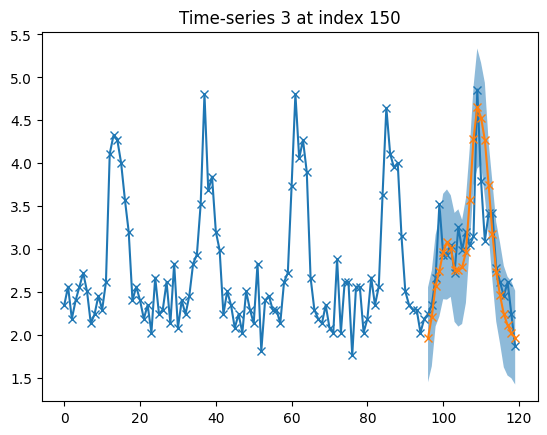

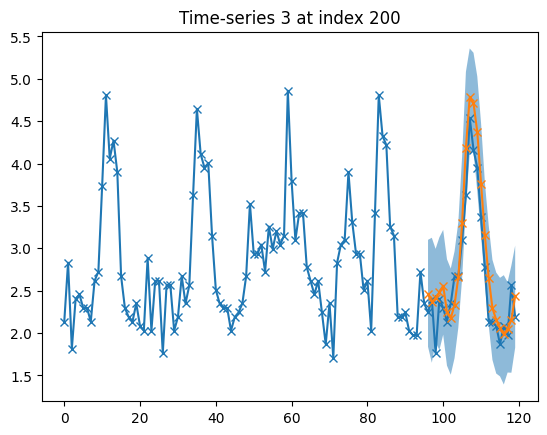

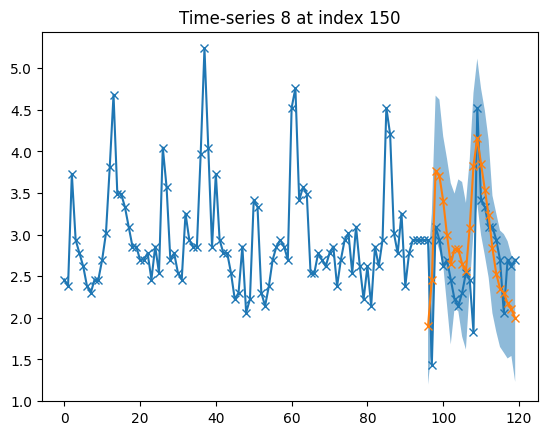

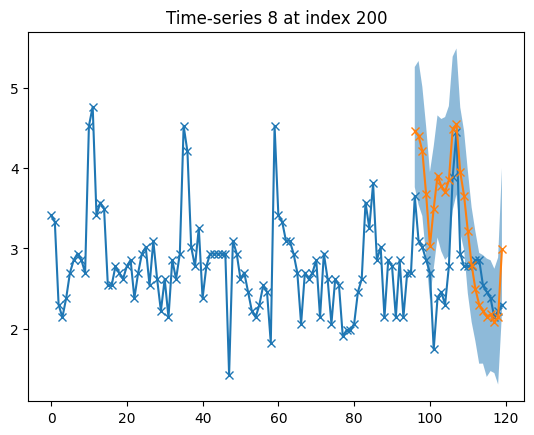

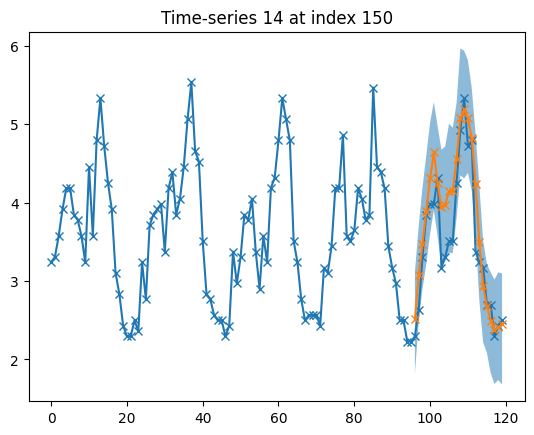

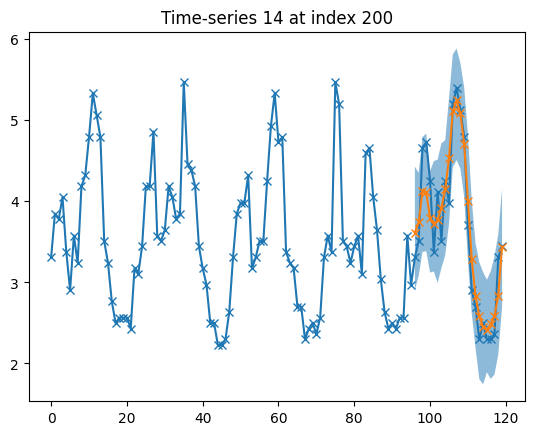

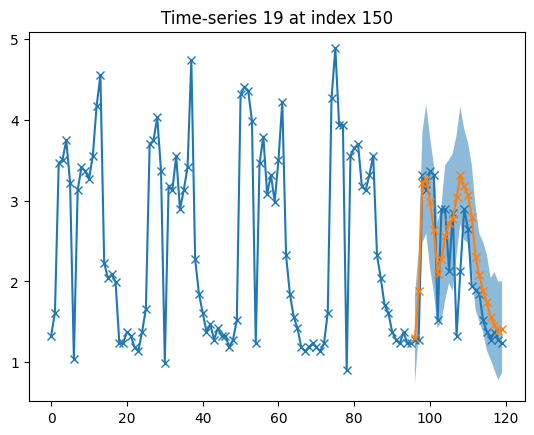

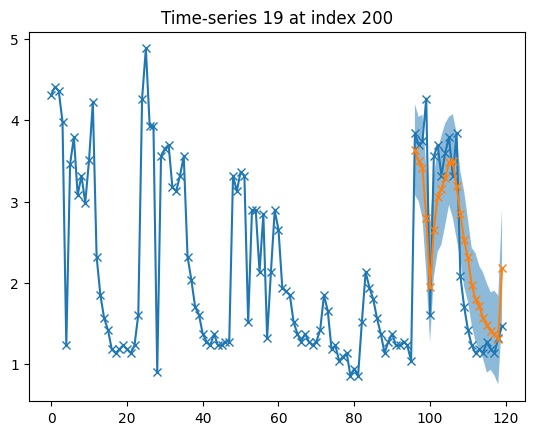

In [8]:
# Sample from model
indices = [150,200]

samples = predictor.sample(
    data = test_dataset,
    indices = indices,
    prediction_length = prediction_length,
    num_samples = 128,
    batch_size = 128,
)
samples = samples.cpu()

# Sort samples in ascending order
samples = samples.permute(0,2,3,1).flatten(start_dim=0,end_dim=2).sort()[0].reshape(samples.shape[0],samples.shape[2],samples.shape[3],-1).permute(0,3,1,2)

# Plot some predictions
confidence = 0.9
for ts, i in itertools.product([3,8,14,19],range(len(indices))):
    plt.figure()
    plt.title(f"Time-series {ts} at index {indices[i]}")
    plt.plot(test_dataset.tensor_data[indices[i]:indices[i]+context_length+prediction_length,ts],"-x")
    plt.plot(list(range(context_length,context_length+prediction_length)),torch.mean(samples[i,:,ts],dim = 0),"-x")
    plt.fill_between(list(range(context_length,context_length+prediction_length)), samples[i,int(confidence*samples.shape[1]),ts], samples[i,int((1-confidence)*samples.shape[1]),ts],alpha=0.5)
    #plt.savefig(f"images/no_shift_{idx}_{ts}.png")

In [9]:
# Make samples and extract realisations for last 14 days of test dataset
indices = list(range(0, 24*14, 24))

samples = predictor.sample(
    data = test_dataset,
    indices = indices,
    prediction_length = prediction_length,
    num_samples = 128,
    batch_size = 128,
)
samples = samples.cpu().numpy()


realisations = []
for idx in indices:
    realisations.append(
        test_data.values[context_length + idx:context_length + idx + prediction_length].T
    )
realisations = np.stack(realisations)


In [10]:
# Calculate metrics
mean_predictions = samples.mean(axis=1)

# MSE, MAE, MDAE
mse = mean_squared_error(realisations.flatten(), mean_predictions.flatten())
mae = mean_absolute_error(realisations.flatten(), mean_predictions.flatten())
mdae = median_absolute_error(realisations.flatten(), mean_predictions.flatten())
print("MSE:", mse, "MAE:", mae, "MDAE:", mdae)

# CRPS_sum and Variogram_score
crps_sum = np.mean([metrics.crps_sum(samples[i], realisations[i]) for i in range(realisations.shape[0])])
variogram_score = np.mean([metrics.variogram_score(samples[i], realisations[i], weights="local", window_size=3) for i in range(realisations.shape[0])])
print("CRPS_sum:", crps_sum, "Variogram_score:", variogram_score)

MSE: 0.23954822498418574 MAE: 0.35186578798395446 MDAE: 0.25287120702316446
CRPS_sum: 10.604960410367877 Variogram_score: 0.0777004878508725


In [ ]:
# Sampling with min/max anchors
indices = list(range(0, 24*14, 24))

max_anchors = 1.1*torch.tensor(train_data.values.max(axis=0),dtype=torch.float32) - 0.1*torch.tensor(train_data.values.mean(axis=0),dtype=torch.float32)
min_anchors = 1.1*torch.tensor(train_data.values.min(axis=0),dtype=torch.float32) - 0.1*torch.tensor(train_data.values.mean(axis=0),dtype=torch.float32)
anchors = torch.stack([min_anchors,max_anchors],dim = -1).unsqueeze(0).unsqueeze(2).repeat((len(indices),1,prediction_length,1))


samples = predictor.sample(
    data = test_dataset,
    indices = indices,
    prediction_length = prediction_length,
    num_samples = 128,
    batch_size = 128,
    anchors = anchors,
    anchor_strength = 0.01,
)
samples = samples.cpu().numpy()


realisations = []
for idx in indices:
    realisations.append(
        test_data.values[context_length + idx:context_length + idx + prediction_length].T
    )
realisations = np.stack(realisations)

In [70]:
# Calculate metrics
mean_predictions = samples.mean(axis=1)

# MSE, MAE, MDAE
mse = mean_squared_error(realisations.flatten(), mean_predictions.flatten())
mae = mean_absolute_error(realisations.flatten(), mean_predictions.flatten())
mdae = median_absolute_error(realisations.flatten(), mean_predictions.flatten())
print("MSE:", mse, "MAE:", mae, "MDAE:", mdae)

# CRPS_sum and Variogram_score
crps_sum = np.mean([metrics.crps_sum(samples[i], realisations[i]) for i in range(realisations.shape[0])])
variogram_score = np.mean([metrics.variogram_score(samples[i], realisations[i], weights="local", window_size=3) for i in range(realisations.shape[0])])
print("CRPS_sum:", crps_sum, "Variogram_score:", variogram_score)

MSE: 0.23900495610628006 MAE: 0.3508197846438903 MDAE: 0.2515496441693834
CRPS_sum: 10.507424604325069 Variogram_score: 0.07724895435368719


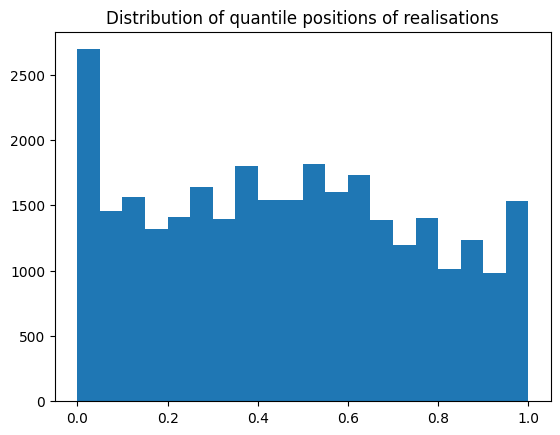

In [18]:
# Check how accurate quantiles are
quantiles = []
for i in range(samples.shape[0]):
    sorted_samples,_ = torch.tensor(samples[i]).flatten(start_dim=1).sort(dim=0)
    real_copy = torch.tensor(realisations[i]).flatten()

    quantiles.append([float((sorted_samples[:,i]<val).double().mean()) for i,val in enumerate(real_copy)])

plt.title("Distribution of quantile positions of realisations")
_ = plt.hist(np.array(quantiles).flatten(),20)